In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c painter-by-numbers

100% 11.1G/11.1G [02:10<00:00, 95.5MB/s]
100% 11.1G/11.1G [02:10<00:00, 91.4MB/s]
100% 36.0G/36.0G [07:57<00:00, 87.0MB/s]
100% 36.0G/36.0G [07:57<00:00, 81.1MB/s]
  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 152MB/s]
 67% 33.0M/49.0M [00:00<00:00, 81.9MB/s]
100% 49.0M/49.0M [00:00<00:00, 110MB/s] 
 99% 110M/111M [00:01<00:00, 73.9MB/s] 
100% 111M/111M [00:01<00:00, 73.8MB/s]
100% 4.75G/4.76G [00:56<00:00, 131MB/s]
100% 4.76G/4.76G [00:56<00:00, 90.5MB/s]
100% 3.68G/3.68G [00:35<00:00, 80.0MB/s]
100% 3.68G/3.68G [00:35<00:00, 110MB/s] 
100% 3.94G/3.95G [00:33<00:00, 110MB/s]
100% 3.95G/3.95G [00:33<00:00, 125MB/s]
100% 3.75G/3.76G [00:37<00:00, 135MB/s]
100% 3.76G/3.76G [00:37<00:00, 108MB/s]
100% 3.89G/3.89G [01:00<00:00, 112MB/s]

100% 3.89G/3.89G [00:53<00:00, 131MB/s]
100% 3.89G/3.89G [00:53<00:00, 78.0MB/s]
100% 4.10G/4.11G [01:03<00:00, 44.0MB/s]
100% 4.11G/4.11G [01:03<00:00, 69.7MB/s]
100% 4.03G/4.03G [00:38<00:00, 119MB/s]
100% 4.03G/4.03G [00:38<00:00, 112MB

In [0]:
!unzip train_1.zip

Archive:  all_data_info.csv.zip
replace all_data_info.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train_1.zip
   creating: train_1/
  inflating: train_1/1.jpg           
  inflating: train_1/10.jpg          
  inflating: train_1/100.jpg         
  inflating: train_1/1000.jpg        
  inflating: train_1/10000.jpg       
  inflating: train_1/100001.jpg      
  inflating: train_1/100002.jpg      
  inflating: train_1/100003.jpg      
  inflating: train_1/100006.jpg      
  inflating: train_1/100007.jpg      
  inflating: train_1/100009.jpg      
  inflating: train_1/10001.jpg       
  inflating: train_1/100010.jpg      
  inflating: train_1/100011.jpg      
  inflating: train_1/100012.jpg      
  inflating: train_1/100013.jpg      
  inflating: train_1/100016.jpg      
  inflating: train_1/100017.jpg      
  inflating: train_1/100019.jpg      
  inflating: train_1/10002.jpg       
  inflating: train_1/100020.jpg      
  inflating: train_1/100021.jpg      
  inflating: train_1/

# Modelo

Para este modelo, se utilizo la arquitectura Call Deep Convolutional Generative Adversial Network (DCGAN).
Fue entrenado utilizando PyTorch

## Importaciones

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import os
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Discriminador

Toma una imagen como input y utiliza varias capas para extraccion de Featuresm y luego una capa para producir un Output.


*   Capa Convolucional con filtros de 4x4, un Stride de 2, y un padding de 1.
*   Normalizacion de capa por Baches
*   Activacion por Leaky Relu

Retorna como Output una activacion de Sigmoide en donde un threshol de 0.5 indica si la imagen es real o falsa



In [0]:
class Discriminator(nn.Module):
    def __init__(self, alpha=0.2):
        super(Discriminator, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        x = self.output(x)
        
        if self.training:
            return x
        
        return F.sigmoid(x)

# Generador

El generador es muy parecido al discriminador, pero en vez de capas convolucionales que reducen la dimension de la imagen, se hace un upscale transpuesto a la convolucion:

![](https://www.ritchievink.com/img/post-16-gan_art/transpc.gif)

Input es azul, output es verde

Las capas del Generador son: 


1.   Normalizacion de Baches
2.   Activacion por Leaky Relu
3.   Capa convolucional transpuesta con filtros 4x4, stride de 2 y padding de 1



In [0]:
class Generator(nn.Module):
    def __init__(self, input_size=200, alpha=0.2):
        super(Generator, self).__init__()       
        kernel_size = 4
        padding = 1
        stride = 2
        
        self.input = nn.Linear(input_size, 4 * 4 * 1024)
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(1024, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 512, kernel_size, stride, padding),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(512, 256, kernel_size, stride, padding),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(alpha),
            nn.ConvTranspose2d(128, 3, kernel_size, stride, padding),
            nn.Tanh()
        )
  
    def forward(self, z):
        x = self.input(z)
        return self.net(x.view(-1, 1024, 4, 4))

El output del Generador es corrido por una funcion de Activacion Tanh, comprimiendo el output entre -1 y 1.

# Pre Procesamiento

El discriminador es quien percive las imagenes reales. Las imagenes tienen que ser re escaladas entre -1 y 1 para que haga match con el output del Generador. Para esto se utilizan funciones ofrecids por PyTorch

In [0]:
class ImageFolderEX(datasets.ImageFolder):
    def __getitem__(self, index):
        def get_img(index):
            path, label = self.imgs[index]
            try:
                img = self.loader(os.path.join(self.root, path))
            except:
                img = get_img(index + 1)
            return img
        img = get_img(index)
        return self.transform(img) * 2 - 1  # re escalar de 0 a 1 -> -1 a 1


trans = transforms.Compose([
    transforms.Resize((256, 256), interpolation=2), 
    transforms.ToTensor(), # Normalizar el input entre 0 y 1
])
'''
# example showing how to use this helper object. 
data = torch.utils.data.DataLoader(ImageFolderEX('/', trans), 
    batch_size=64, shuffle=True, drop_last=True, num_workers=0)
x = next(iter(data))
'''

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


# Training

Para estabilizar el aprendizaje de la red se implemento lo siguiente:


*   Construir diferentes mini baches para data real y falsa
*   Soft Labels para el Discriminador
*   Utilizar hiperparametros de Adam



In [0]:
def train_dis(dis, gen, x):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)

    if next(gen.parameters()).is_cuda:
        x = x.cuda()
        z = z.cuda()

    dis.zero_grad()
    y_real_pred = dis(x)
    
    idx = np.random.uniform(0, 1, y_real_pred.shape)
    idx = np.argwhere(idx < 0.03)
    
    # cambio de labels
    ones = np.ones(y_real_pred.shape) + np.random.uniform(-0.1, 0.1)
    ones[idx] = 0
    
    zeros = np.zeros(y_real_pred.shape) + np.random.uniform(0, 0.2)
    zeros[idx] = 1
    ones = torch.from_numpy(ones).float()
    zeros = torch.from_numpy(zeros).float()

    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()
        zeros = zeros.cuda()

    loss_real = F.binary_cross_entropy_with_logits(y_real_pred, ones)

    generated = gen(z)
    y_fake_pred = dis(generated)

    loss_fake = F.binary_cross_entropy_with_logits(y_fake_pred, zeros)
    loss = loss_fake + loss_real
    loss.backward()
    optimizer_dis.step()
    return loss

            
def train_gen(gen, batch_size):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32)
    
    if next(gen.parameters()).is_cuda:
        z = z.cuda()
    
    gen.zero_grad()
    generated = gen(z)
    y_fake = dis(generated)

    ones = torch.ones_like(y_fake)
    if next(gen.parameters()).is_cuda:
        ones = ones.cuda()

    loss = F.binary_cross_entropy_with_logits(y_fake, ones)
    loss.backward()
    optimizer_gen.step()
    return loss, generated

# Training Loop

In [0]:
dis = Discriminator().cuda()
gen = Generator().cuda()

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
optimizer_gen = torch.optim.Adam(gen.parameters(), lr, betas=(beta_1, beta_2))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr, betas=(beta_1, beta_2))

epochs = 20
batch_size = 64
data = torch.utils.data.DataLoader(ImageFolderEX('/', trans), 
                   batch_size=batch_size, shuffle=True, 
                   drop_last=True, num_workers=2)

n = len(data)
for epoch in range(0, epochs):
    c = 0
    n = len(data) 

    for x in iter(data): 
        c += 1

        loss_dis = train_dis(dis, gen, x)
        loss_gen, generated = train_gen(gen, batch_size)
        
        global_step = epoch * n + c

        if c % 4 == 0:
            print(f'loss: {loss_dis.item()}, \t {loss_gen.item()} \t epoch: {epoch}, \t {c}/{n}')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 6.11135196685791, 	 7.553417205810547 	 epoch: 0, 	 4/216
loss: 1.5357379913330078, 	 10.598188400268555 	 epoch: 0, 	 8/216
loss: 1.9736825227737427, 	 7.48928689956665 	 epoch: 0, 	 12/216
loss: 0.734709620475769, 	 5.458573341369629 	 epoch: 0, 	 16/216
loss: 0.8073186874389648, 	 5.039649963378906 	 epoch: 0, 	 20/216
loss: 0.772702693939209, 	 1.701749563217163 	 epoch: 0, 	 24/216
loss: 4.424392223358154, 	 4.830946922302246 	 epoch: 0, 	 28/216
loss: 1.1641902923583984, 	 1.7086429595947266 	 epoch: 0, 	 32/216
loss: 1.5505170822143555, 	 5.742518424987793 	 epoch: 0, 	 36/216
loss: 0.834148645401001, 	 4.944298267364502 	 epoch: 0, 	 40/216
loss: 0.48018407821655273, 	 1.6284527778625488 	 epoch: 0, 	 44/216
loss: 0.8180698752403259, 	 2.0519661903381348 	 epoch: 0, 	 48/216
loss: 0.41853076219558716, 	 2.696650981903076 	 epoch: 0, 	 52/216
loss: 0.9919427633285522, 	 1.3635109663009644 	 epoch: 0, 	 56/216
loss: 1.007176160812378, 	 2.130505323410034 	 epoch: 0, 	 60/21

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.8453553318977356, 	 3.1038036346435547 	 epoch: 0, 	 84/216
loss: 0.4243627190589905, 	 3.529761791229248 	 epoch: 0, 	 88/216
loss: 0.11335884779691696, 	 4.882244110107422 	 epoch: 0, 	 92/216
loss: 0.8579369783401489, 	 1.9762403964996338 	 epoch: 0, 	 96/216
loss: 1.0726499557495117, 	 2.1352367401123047 	 epoch: 0, 	 100/216
loss: 0.8171349167823792, 	 0.969756007194519 	 epoch: 0, 	 104/216
loss: 2.3901045322418213, 	 6.436532497406006 	 epoch: 0, 	 108/216
loss: 0.5785924196243286, 	 2.418806552886963 	 epoch: 0, 	 112/216
loss: 0.9552533626556396, 	 4.923364162445068 	 epoch: 0, 	 116/216
loss: 1.044690489768982, 	 2.3487157821655273 	 epoch: 0, 	 120/216
loss: 0.9952272772789001, 	 4.713120460510254 	 epoch: 0, 	 124/216
loss: 0.24859078228473663, 	 2.8115572929382324 	 epoch: 0, 	 128/216
loss: 0.356141060590744, 	 2.8933236598968506 	 epoch: 0, 	 132/216
loss: 0.5227375030517578, 	 3.5670166015625 	 epoch: 0, 	 136/216
loss: 0.7958287000656128, 	 1.6165807247161865 	

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.40696215629577637, 	 2.4805774688720703 	 epoch: 1, 	 4/216
loss: 0.7168782949447632, 	 2.3381290435791016 	 epoch: 1, 	 8/216
loss: 0.22181189060211182, 	 2.234034776687622 	 epoch: 1, 	 12/216
loss: 0.9326037168502808, 	 1.7110471725463867 	 epoch: 1, 	 16/216
loss: 0.7516708970069885, 	 2.0445258617401123 	 epoch: 1, 	 20/216
loss: 0.36344578862190247, 	 1.3434267044067383 	 epoch: 1, 	 24/216
loss: 0.8182122707366943, 	 1.9354768991470337 	 epoch: 1, 	 28/216
loss: 0.33173489570617676, 	 2.429971933364868 	 epoch: 1, 	 32/216
loss: 0.805424690246582, 	 2.2506520748138428 	 epoch: 1, 	 36/216
loss: 0.7373694181442261, 	 2.1405043601989746 	 epoch: 1, 	 40/216
loss: 0.5833708047866821, 	 1.9779810905456543 	 epoch: 1, 	 44/216
loss: 0.6602053642272949, 	 1.8291845321655273 	 epoch: 1, 	 48/216
loss: 0.8046307563781738, 	 2.58943510055542 	 epoch: 1, 	 52/216
loss: 0.2098260372877121, 	 2.2085132598876953 	 epoch: 1, 	 56/216
loss: 0.46493178606033325, 	 2.5869739055633545 	 e

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.4379594624042511, 	 2.351088523864746 	 epoch: 1, 	 132/216
loss: 0.7675146460533142, 	 0.9260091185569763 	 epoch: 1, 	 136/216
loss: 1.5095993280410767, 	 2.24526309967041 	 epoch: 1, 	 140/216
loss: 0.6928536891937256, 	 2.1761748790740967 	 epoch: 1, 	 144/216
loss: 0.7884938716888428, 	 2.1337733268737793 	 epoch: 1, 	 148/216
loss: 0.6063641309738159, 	 2.335205078125 	 epoch: 1, 	 152/216
loss: 0.7788152694702148, 	 3.0540804862976074 	 epoch: 1, 	 156/216
loss: 1.286185383796692, 	 2.053149700164795 	 epoch: 1, 	 160/216
loss: 1.2120903730392456, 	 1.5918033123016357 	 epoch: 1, 	 164/216
loss: 1.066375732421875, 	 2.9039483070373535 	 epoch: 1, 	 168/216
loss: 1.4697920083999634, 	 2.4420979022979736 	 epoch: 1, 	 172/216
loss: 0.7045990228652954, 	 2.289292335510254 	 epoch: 1, 	 176/216
loss: 1.5373241901397705, 	 1.9323047399520874 	 epoch: 1, 	 180/216
loss: 0.7936385869979858, 	 2.0689949989318848 	 epoch: 1, 	 184/216
loss: 3.5810673236846924, 	 3.033037662506103

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.8390966653823853, 	 1.9302151203155518 	 epoch: 2, 	 4/216
loss: 0.9098299741744995, 	 1.8608193397521973 	 epoch: 2, 	 8/216
loss: 0.8354501724243164, 	 2.009740114212036 	 epoch: 2, 	 12/216
loss: 1.4071969985961914, 	 1.8547906875610352 	 epoch: 2, 	 16/216
loss: 0.7697508335113525, 	 1.9625087976455688 	 epoch: 2, 	 20/216
loss: 0.7853567600250244, 	 2.7272958755493164 	 epoch: 2, 	 24/216
loss: 1.052199363708496, 	 0.9585633873939514 	 epoch: 2, 	 28/216
loss: 1.0640559196472168, 	 2.2501325607299805 	 epoch: 2, 	 32/216
loss: 1.1181576251983643, 	 2.3126626014709473 	 epoch: 2, 	 36/216
loss: 1.95473313331604, 	 2.415076494216919 	 epoch: 2, 	 40/216
loss: 1.223790168762207, 	 1.8348654508590698 	 epoch: 2, 	 44/216
loss: 0.7588055729866028, 	 3.2625091075897217 	 epoch: 2, 	 48/216
loss: 1.1174647808074951, 	 4.080753326416016 	 epoch: 2, 	 52/216
loss: 1.1192474365234375, 	 2.051187038421631 	 epoch: 2, 	 56/216
loss: 0.8505430817604065, 	 1.5975830554962158 	 epoch: 2,

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.9647786021232605, 	 2.147329092025757 	 epoch: 2, 	 116/216
loss: 0.7639594078063965, 	 1.3722542524337769 	 epoch: 2, 	 120/216
loss: 1.2813485860824585, 	 1.0220435857772827 	 epoch: 2, 	 124/216
loss: 1.0909309387207031, 	 0.9050717353820801 	 epoch: 2, 	 128/216
loss: 0.9175255298614502, 	 1.2874857187271118 	 epoch: 2, 	 132/216
loss: 0.834283709526062, 	 1.6690442562103271 	 epoch: 2, 	 136/216
loss: 0.7731302976608276, 	 1.8777612447738647 	 epoch: 2, 	 140/216
loss: 0.7540062069892883, 	 0.1517365574836731 	 epoch: 2, 	 144/216
loss: 0.7258284091949463, 	 1.4954262971878052 	 epoch: 2, 	 148/216
loss: 0.5068615674972534, 	 3.025775909423828 	 epoch: 2, 	 152/216
loss: 1.437255859375, 	 1.746524691581726 	 epoch: 2, 	 156/216
loss: 1.4229114055633545, 	 2.1131174564361572 	 epoch: 2, 	 160/216
loss: 0.7521597146987915, 	 1.984298586845398 	 epoch: 2, 	 164/216
loss: 1.1396472454071045, 	 3.9792122840881348 	 epoch: 2, 	 168/216
loss: 0.8518670797348022, 	 2.4058609008789

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.5568065047264099, 	 3.9509382247924805 	 epoch: 3, 	 4/216
loss: 1.5206427574157715, 	 1.4015531539916992 	 epoch: 3, 	 8/216
loss: 0.8573916554450989, 	 2.330693244934082 	 epoch: 3, 	 12/216
loss: 1.4013210535049438, 	 4.626492500305176 	 epoch: 3, 	 16/216
loss: 0.9872342348098755, 	 2.5218582153320312 	 epoch: 3, 	 20/216
loss: 1.0993400812149048, 	 2.5066628456115723 	 epoch: 3, 	 24/216
loss: 0.6129505038261414, 	 3.581058979034424 	 epoch: 3, 	 28/216
loss: 0.682417631149292, 	 2.0733795166015625 	 epoch: 3, 	 32/216
loss: 1.0264513492584229, 	 5.909452438354492 	 epoch: 3, 	 36/216
loss: 1.1755229234695435, 	 2.9056825637817383 	 epoch: 3, 	 40/216
loss: 0.8766997456550598, 	 1.0675702095031738 	 epoch: 3, 	 44/216
loss: 0.729331374168396, 	 1.2429521083831787 	 epoch: 3, 	 48/216
loss: 1.0391651391983032, 	 1.5281693935394287 	 epoch: 3, 	 52/216
loss: 2.536210536956787, 	 0.9362969398498535 	 epoch: 3, 	 56/216
loss: 0.9804244041442871, 	 1.4338291883468628 	 epoch: 3

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.7523061633110046, 	 2.8092868328094482 	 epoch: 3, 	 68/216
loss: 0.7498000860214233, 	 1.3675498962402344 	 epoch: 3, 	 72/216
loss: 1.7445099353790283, 	 2.4237353801727295 	 epoch: 3, 	 76/216
loss: 1.143819808959961, 	 1.4672822952270508 	 epoch: 3, 	 80/216
loss: 1.0928630828857422, 	 1.352789282798767 	 epoch: 3, 	 84/216
loss: 2.1839592456817627, 	 0.7284904718399048 	 epoch: 3, 	 88/216
loss: 1.04555344581604, 	 1.315658450126648 	 epoch: 3, 	 92/216
loss: 1.4729812145233154, 	 1.235757827758789 	 epoch: 3, 	 96/216
loss: 0.9472408294677734, 	 2.2541232109069824 	 epoch: 3, 	 100/216
loss: 0.8920224905014038, 	 1.2429229021072388 	 epoch: 3, 	 104/216
loss: 1.4922518730163574, 	 3.9475250244140625 	 epoch: 3, 	 108/216
loss: 0.7368898987770081, 	 2.852532386779785 	 epoch: 3, 	 112/216
loss: 1.025959849357605, 	 0.5710760354995728 	 epoch: 3, 	 116/216
loss: 1.5615673065185547, 	 2.923126220703125 	 epoch: 3, 	 120/216
loss: 1.4297630786895752, 	 0.8681855201721191 	 ep

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.287719488143921, 	 3.554014205932617 	 epoch: 4, 	 4/216
loss: 1.7471468448638916, 	 6.155081748962402 	 epoch: 4, 	 8/216
loss: 0.6707270741462708, 	 2.1653430461883545 	 epoch: 4, 	 12/216
loss: 1.0866284370422363, 	 2.6101813316345215 	 epoch: 4, 	 16/216
loss: 0.6956495046615601, 	 2.051602363586426 	 epoch: 4, 	 20/216
loss: 0.8642135858535767, 	 1.9482332468032837 	 epoch: 4, 	 24/216
loss: 1.275001049041748, 	 1.2085644006729126 	 epoch: 4, 	 28/216
loss: 1.1512904167175293, 	 1.469383716583252 	 epoch: 4, 	 32/216
loss: 0.529954731464386, 	 2.898421049118042 	 epoch: 4, 	 36/216
loss: 1.6392767429351807, 	 3.7503013610839844 	 epoch: 4, 	 40/216
loss: 0.6605849266052246, 	 2.6008358001708984 	 epoch: 4, 	 44/216
loss: 0.7384833693504333, 	 2.3251538276672363 	 epoch: 4, 	 48/216
loss: 1.0913960933685303, 	 3.8599705696105957 	 epoch: 4, 	 52/216
loss: 0.9694535732269287, 	 1.4020612239837646 	 epoch: 4, 	 56/216
loss: 0.9921663403511047, 	 3.2713918685913086 	 epoch: 4,

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.2025291919708252, 	 1.1712238788604736 	 epoch: 4, 	 88/216
loss: 1.0642657279968262, 	 1.169927716255188 	 epoch: 4, 	 92/216
loss: 0.9157040119171143, 	 1.6403758525848389 	 epoch: 4, 	 96/216
loss: 1.0727225542068481, 	 2.528660774230957 	 epoch: 4, 	 100/216
loss: 1.119016170501709, 	 3.5301260948181152 	 epoch: 4, 	 104/216
loss: 1.4962071180343628, 	 3.2372546195983887 	 epoch: 4, 	 108/216
loss: 0.9405611157417297, 	 2.480807065963745 	 epoch: 4, 	 112/216
loss: 2.009369134902954, 	 1.1595792770385742 	 epoch: 4, 	 116/216
loss: 0.9318872690200806, 	 1.9258538484573364 	 epoch: 4, 	 120/216
loss: 0.8913907408714294, 	 2.172175407409668 	 epoch: 4, 	 124/216
loss: 1.3496791124343872, 	 1.7915524244308472 	 epoch: 4, 	 128/216
loss: 0.700490415096283, 	 1.624510645866394 	 epoch: 4, 	 132/216
loss: 3.3865866661071777, 	 0.610256016254425 	 epoch: 4, 	 136/216
loss: 0.8157806396484375, 	 1.2508243322372437 	 epoch: 4, 	 140/216
loss: 1.1030793190002441, 	 1.2468674182891846

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.274266242980957, 	 1.2579988241195679 	 epoch: 5, 	 4/216
loss: 1.2024288177490234, 	 0.3902136981487274 	 epoch: 5, 	 8/216
loss: 1.1753263473510742, 	 2.037609577178955 	 epoch: 5, 	 12/216
loss: 1.1226356029510498, 	 2.2550454139709473 	 epoch: 5, 	 16/216
loss: 1.223942518234253, 	 2.7382493019104004 	 epoch: 5, 	 20/216
loss: 1.058652400970459, 	 2.586334705352783 	 epoch: 5, 	 24/216
loss: 0.832510769367218, 	 2.9091763496398926 	 epoch: 5, 	 28/216
loss: 1.4302207231521606, 	 5.273970603942871 	 epoch: 5, 	 32/216
loss: 1.287603497505188, 	 2.1010122299194336 	 epoch: 5, 	 36/216
loss: 1.0391191244125366, 	 2.4120450019836426 	 epoch: 5, 	 40/216
loss: 0.8645737171173096, 	 1.5433838367462158 	 epoch: 5, 	 44/216
loss: 0.6805054545402527, 	 2.1231212615966797 	 epoch: 5, 	 48/216
loss: 1.796339750289917, 	 1.1191641092300415 	 epoch: 5, 	 52/216
loss: 1.4855151176452637, 	 2.577256917953491 	 epoch: 5, 	 56/216
loss: 0.9054595232009888, 	 2.5044078826904297 	 epoch: 5, 	

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.0530805587768555, 	 1.9814682006835938 	 epoch: 5, 	 156/216
loss: 1.01649808883667, 	 2.245060920715332 	 epoch: 5, 	 160/216
loss: 1.0170207023620605, 	 0.89906907081604 	 epoch: 5, 	 164/216
loss: 0.8722054958343506, 	 1.5551784038543701 	 epoch: 5, 	 168/216
loss: 1.0047435760498047, 	 2.099386692047119 	 epoch: 5, 	 172/216
loss: 0.7599843740463257, 	 0.8255518078804016 	 epoch: 5, 	 176/216
loss: 0.6645658016204834, 	 2.1368699073791504 	 epoch: 5, 	 180/216
loss: 1.3322553634643555, 	 4.2412638664245605 	 epoch: 5, 	 184/216
loss: 0.7650774717330933, 	 1.5323107242584229 	 epoch: 5, 	 188/216
loss: 2.082533836364746, 	 3.4858927726745605 	 epoch: 5, 	 192/216
loss: 1.03072190284729, 	 1.9516372680664062 	 epoch: 5, 	 196/216
loss: 0.9120171070098877, 	 2.329753875732422 	 epoch: 5, 	 200/216
loss: 0.8048861026763916, 	 2.157902717590332 	 epoch: 5, 	 204/216
loss: 0.9748753905296326, 	 1.6216799020767212 	 epoch: 5, 	 208/216
loss: 1.1990017890930176, 	 2.617630481719970

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.3703033924102783, 	 1.8616416454315186 	 epoch: 6, 	 4/216
loss: 1.173840880393982, 	 2.25754976272583 	 epoch: 6, 	 8/216
loss: 0.8627974987030029, 	 5.872635841369629 	 epoch: 6, 	 12/216
loss: 2.173780918121338, 	 4.818111419677734 	 epoch: 6, 	 16/216
loss: 1.3422578573226929, 	 1.4905462265014648 	 epoch: 6, 	 20/216
loss: 0.6127627491950989, 	 1.4875819683074951 	 epoch: 6, 	 24/216
loss: 0.8815970420837402, 	 1.6312520503997803 	 epoch: 6, 	 28/216
loss: 1.035660982131958, 	 1.9825083017349243 	 epoch: 6, 	 32/216
loss: 0.9726027846336365, 	 1.247727394104004 	 epoch: 6, 	 36/216
loss: 0.9761435389518738, 	 2.4844939708709717 	 epoch: 6, 	 40/216
loss: 0.8182671070098877, 	 1.0117428302764893 	 epoch: 6, 	 44/216
loss: 1.321198582649231, 	 3.14865779876709 	 epoch: 6, 	 48/216
loss: 1.0968637466430664, 	 1.901265263557434 	 epoch: 6, 	 52/216
loss: 1.2876588106155396, 	 4.436367988586426 	 epoch: 6, 	 56/216
loss: 1.399844765663147, 	 1.3623623847961426 	 epoch: 6, 	 60/

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.1113988161087036, 	 1.8138723373413086 	 epoch: 6, 	 168/216
loss: 0.8916841149330139, 	 1.6315398216247559 	 epoch: 6, 	 172/216
loss: 0.8933572769165039, 	 3.0653419494628906 	 epoch: 6, 	 176/216
loss: 0.7896938920021057, 	 1.8324100971221924 	 epoch: 6, 	 180/216
loss: 1.0701994895935059, 	 4.44053316116333 	 epoch: 6, 	 184/216
loss: 1.778806209564209, 	 0.5853307247161865 	 epoch: 6, 	 188/216
loss: 0.7319280505180359, 	 1.2487289905548096 	 epoch: 6, 	 192/216
loss: 1.0728070735931396, 	 3.505683183670044 	 epoch: 6, 	 196/216
loss: 1.174285650253296, 	 2.609901189804077 	 epoch: 6, 	 200/216
loss: 1.2291887998580933, 	 3.374134063720703 	 epoch: 6, 	 204/216
loss: 1.0029100179672241, 	 1.7131831645965576 	 epoch: 6, 	 208/216
loss: 1.0879191160202026, 	 2.3721165657043457 	 epoch: 6, 	 212/216
loss: 0.9030702710151672, 	 2.0668675899505615 	 epoch: 6, 	 216/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.9754696488380432, 	 1.5585252046585083 	 epoch: 7, 	 4/216
loss: 1.1923171281814575, 	 2.715946674346924 	 epoch: 7, 	 8/216
loss: 0.4118475019931793, 	 1.7045941352844238 	 epoch: 7, 	 12/216
loss: 1.0352282524108887, 	 1.028318166732788 	 epoch: 7, 	 16/216
loss: 1.0138221979141235, 	 1.9082424640655518 	 epoch: 7, 	 20/216
loss: 1.2744556665420532, 	 2.6538619995117188 	 epoch: 7, 	 24/216
loss: 0.6401417851448059, 	 2.1457128524780273 	 epoch: 7, 	 28/216
loss: 0.7981288433074951, 	 2.0756640434265137 	 epoch: 7, 	 32/216
loss: 0.7904081344604492, 	 1.6286009550094604 	 epoch: 7, 	 36/216
loss: 0.4481441378593445, 	 4.541931629180908 	 epoch: 7, 	 40/216
loss: 1.4074935913085938, 	 2.9116337299346924 	 epoch: 7, 	 44/216
loss: 1.0325971841812134, 	 1.1476819515228271 	 epoch: 7, 	 48/216
loss: 1.0911853313446045, 	 1.3680176734924316 	 epoch: 7, 	 52/216
loss: 0.9578483700752258, 	 0.9319836497306824 	 epoch: 7, 	 56/216
loss: 1.2691470384597778, 	 0.9309126734733582 	 epoc

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.5512426495552063, 	 1.300330400466919 	 epoch: 7, 	 164/216
loss: 0.9779804348945618, 	 1.0463602542877197 	 epoch: 7, 	 168/216
loss: 0.9445075988769531, 	 1.7371160984039307 	 epoch: 7, 	 172/216
loss: 1.0253143310546875, 	 2.0827436447143555 	 epoch: 7, 	 176/216
loss: 0.9653351902961731, 	 2.500527858734131 	 epoch: 7, 	 180/216
loss: 0.98206627368927, 	 2.2694785594940186 	 epoch: 7, 	 184/216
loss: 2.1731038093566895, 	 0.8430399298667908 	 epoch: 7, 	 188/216
loss: 1.0541765689849854, 	 1.3783128261566162 	 epoch: 7, 	 192/216
loss: 0.6760139465332031, 	 1.4192869663238525 	 epoch: 7, 	 196/216
loss: 1.097781777381897, 	 2.290992259979248 	 epoch: 7, 	 200/216
loss: 0.669552743434906, 	 2.1750454902648926 	 epoch: 7, 	 204/216
loss: 2.6104183197021484, 	 1.5664043426513672 	 epoch: 7, 	 208/216
loss: 1.0127081871032715, 	 1.0455595254898071 	 epoch: 7, 	 212/216
loss: 0.8901157379150391, 	 1.491018533706665 	 epoch: 7, 	 216/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.9167946577072144, 	 2.4922642707824707 	 epoch: 8, 	 4/216
loss: 0.8511134386062622, 	 1.6357048749923706 	 epoch: 8, 	 8/216
loss: 0.9702916741371155, 	 3.4274933338165283 	 epoch: 8, 	 12/216
loss: 0.6635431051254272, 	 3.218595027923584 	 epoch: 8, 	 16/216
loss: 1.6197779178619385, 	 0.8284539580345154 	 epoch: 8, 	 20/216
loss: 1.3827797174453735, 	 0.9434385895729065 	 epoch: 8, 	 24/216
loss: 1.0466433763504028, 	 1.5369150638580322 	 epoch: 8, 	 28/216
loss: 0.8434017896652222, 	 1.6933693885803223 	 epoch: 8, 	 32/216
loss: 1.0141935348510742, 	 1.8016548156738281 	 epoch: 8, 	 36/216
loss: 0.7747722864151001, 	 1.7682406902313232 	 epoch: 8, 	 40/216
loss: 0.6636793613433838, 	 1.6642050743103027 	 epoch: 8, 	 44/216
loss: 2.313293695449829, 	 1.5305733680725098 	 epoch: 8, 	 48/216
loss: 1.2973461151123047, 	 0.9851440191268921 	 epoch: 8, 	 52/216
loss: 1.1132458448410034, 	 1.703810214996338 	 epoch: 8, 	 56/216
loss: 0.8913387060165405, 	 2.8359265327453613 	 epoc

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.1493587493896484, 	 3.102496862411499 	 epoch: 9, 	 4/216
loss: 0.8421065807342529, 	 1.8964905738830566 	 epoch: 9, 	 8/216
loss: 0.9994637966156006, 	 2.111741065979004 	 epoch: 9, 	 12/216
loss: 1.0019633769989014, 	 1.9377479553222656 	 epoch: 9, 	 16/216
loss: 1.3582558631896973, 	 1.5962574481964111 	 epoch: 9, 	 20/216
loss: 0.7826417088508606, 	 1.916223406791687 	 epoch: 9, 	 24/216
loss: 0.6797000765800476, 	 2.016413450241089 	 epoch: 9, 	 28/216
loss: 1.591856837272644, 	 0.8529863357543945 	 epoch: 9, 	 32/216
loss: 1.530782699584961, 	 0.671457052230835 	 epoch: 9, 	 36/216
loss: 1.0888826847076416, 	 3.8783860206604004 	 epoch: 9, 	 40/216
loss: 1.328127384185791, 	 1.1289172172546387 	 epoch: 9, 	 44/216
loss: 1.0543707609176636, 	 0.7670392394065857 	 epoch: 9, 	 48/216
loss: 0.698313295841217, 	 2.9111828804016113 	 epoch: 9, 	 52/216
loss: 1.7607004642486572, 	 0.838234543800354 	 epoch: 9, 	 56/216
loss: 0.6885684132575989, 	 1.6093695163726807 	 epoch: 9, 	

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.9038562774658203, 	 3.4528393745422363 	 epoch: 9, 	 140/216
loss: 0.8124358654022217, 	 2.1801936626434326 	 epoch: 9, 	 144/216
loss: 1.439734697341919, 	 4.780604839324951 	 epoch: 9, 	 148/216
loss: 0.9196432828903198, 	 3.44193172454834 	 epoch: 9, 	 152/216
loss: 1.7411911487579346, 	 0.9150463938713074 	 epoch: 9, 	 156/216
loss: 1.055610179901123, 	 1.993564248085022 	 epoch: 9, 	 160/216
loss: 0.9385178089141846, 	 2.799746513366699 	 epoch: 9, 	 164/216
loss: 1.0940543413162231, 	 2.6758341789245605 	 epoch: 9, 	 168/216
loss: 1.18222975730896, 	 1.6946560144424438 	 epoch: 9, 	 172/216
loss: 0.6332864165306091, 	 0.4540613889694214 	 epoch: 9, 	 176/216
loss: 0.9617267847061157, 	 1.2799623012542725 	 epoch: 9, 	 180/216
loss: 0.9547958374023438, 	 1.8560295104980469 	 epoch: 9, 	 184/216
loss: 1.0334887504577637, 	 2.530714988708496 	 epoch: 9, 	 188/216
loss: 1.195573091506958, 	 2.5585875511169434 	 epoch: 9, 	 192/216
loss: 1.4506211280822754, 	 1.241788387298584

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.0571001768112183, 	 1.252111554145813 	 epoch: 10, 	 4/216
loss: 1.4374470710754395, 	 1.1735131740570068 	 epoch: 10, 	 8/216
loss: 1.0179073810577393, 	 1.3520232439041138 	 epoch: 10, 	 12/216
loss: 1.0254379510879517, 	 1.633807897567749 	 epoch: 10, 	 16/216
loss: 1.3734214305877686, 	 1.02936851978302 	 epoch: 10, 	 20/216
loss: 0.9354369044303894, 	 1.5264822244644165 	 epoch: 10, 	 24/216
loss: 0.3984483778476715, 	 1.397660255432129 	 epoch: 10, 	 28/216
loss: 0.7222633361816406, 	 3.2038497924804688 	 epoch: 10, 	 32/216
loss: 0.8750991821289062, 	 0.6445842981338501 	 epoch: 10, 	 36/216
loss: 1.138113021850586, 	 1.2853946685791016 	 epoch: 10, 	 40/216
loss: 1.4610272645950317, 	 2.4978227615356445 	 epoch: 10, 	 44/216
loss: 1.4385602474212646, 	 0.8276535272598267 	 epoch: 10, 	 48/216
loss: 0.8627499341964722, 	 1.854317307472229 	 epoch: 10, 	 52/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.0518250465393066, 	 3.183192253112793 	 epoch: 10, 	 56/216
loss: 1.197739839553833, 	 1.0620523691177368 	 epoch: 10, 	 60/216
loss: 1.6240053176879883, 	 1.1511681079864502 	 epoch: 10, 	 64/216
loss: 0.7380157709121704, 	 1.5652776956558228 	 epoch: 10, 	 68/216
loss: 1.1899523735046387, 	 3.832448959350586 	 epoch: 10, 	 72/216
loss: 0.8378094434738159, 	 4.176553249359131 	 epoch: 10, 	 76/216
loss: 1.1127355098724365, 	 1.4443055391311646 	 epoch: 10, 	 80/216
loss: 0.995543897151947, 	 1.858946681022644 	 epoch: 10, 	 84/216
loss: 0.6531393527984619, 	 1.3508551120758057 	 epoch: 10, 	 88/216
loss: 1.3239575624465942, 	 3.285031795501709 	 epoch: 10, 	 92/216
loss: 0.9582565426826477, 	 3.1499524116516113 	 epoch: 10, 	 96/216
loss: 1.0626459121704102, 	 0.5430506467819214 	 epoch: 10, 	 100/216
loss: 0.8946614265441895, 	 1.2020068168640137 	 epoch: 10, 	 104/216
loss: 1.1837701797485352, 	 0.9030008316040039 	 epoch: 10, 	 108/216
loss: 1.0098397731781006, 	 0.97287642

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.8831660747528076, 	 2.1157214641571045 	 epoch: 11, 	 4/216
loss: 1.3885198831558228, 	 1.620162010192871 	 epoch: 11, 	 8/216
loss: 0.7804343700408936, 	 2.0969364643096924 	 epoch: 11, 	 12/216
loss: 1.055154800415039, 	 1.6530935764312744 	 epoch: 11, 	 16/216
loss: 1.3648533821105957, 	 1.5716427564620972 	 epoch: 11, 	 20/216
loss: 0.8103922605514526, 	 2.653533935546875 	 epoch: 11, 	 24/216
loss: 0.9071074724197388, 	 2.0621700286865234 	 epoch: 11, 	 28/216
loss: 1.0119673013687134, 	 1.2430015802383423 	 epoch: 11, 	 32/216
loss: 1.0063257217407227, 	 2.840747833251953 	 epoch: 11, 	 36/216
loss: 0.903631865978241, 	 1.422906756401062 	 epoch: 11, 	 40/216
loss: 1.0578303337097168, 	 1.7915480136871338 	 epoch: 11, 	 44/216
loss: 0.784111738204956, 	 1.818185806274414 	 epoch: 11, 	 48/216
loss: 0.9957774877548218, 	 1.6701394319534302 	 epoch: 11, 	 52/216
loss: 0.985912561416626, 	 1.9097477197647095 	 epoch: 11, 	 56/216
loss: 1.5770474672317505, 	 0.571862757205963

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.42634230852127075, 	 2.1201515197753906 	 epoch: 11, 	 88/216
loss: 1.4901319742202759, 	 0.7340524196624756 	 epoch: 11, 	 92/216
loss: 0.7508553266525269, 	 2.6844305992126465 	 epoch: 11, 	 96/216
loss: 1.0177797079086304, 	 1.3630417585372925 	 epoch: 11, 	 100/216
loss: 1.6050243377685547, 	 3.419351577758789 	 epoch: 11, 	 104/216
loss: 0.9349623918533325, 	 1.7246670722961426 	 epoch: 11, 	 108/216
loss: 1.0554823875427246, 	 2.2111408710479736 	 epoch: 11, 	 112/216
loss: 0.6512178182601929, 	 3.0585527420043945 	 epoch: 11, 	 116/216
loss: 0.7025028467178345, 	 1.7834092378616333 	 epoch: 11, 	 120/216
loss: 1.087503433227539, 	 3.416304588317871 	 epoch: 11, 	 124/216
loss: 1.426879644393921, 	 0.05086227133870125 	 epoch: 11, 	 128/216
loss: 0.8694034814834595, 	 2.2528605461120605 	 epoch: 11, 	 132/216
loss: 0.9991338849067688, 	 1.535776972770691 	 epoch: 11, 	 136/216
loss: 0.9219832420349121, 	 2.341080904006958 	 epoch: 11, 	 140/216
loss: 1.7534101009368896, 	

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.28526461124420166, 	 1.8426865339279175 	 epoch: 12, 	 4/216
loss: 0.9240855574607849, 	 0.8691881895065308 	 epoch: 12, 	 8/216
loss: 0.5897188782691956, 	 1.3173216581344604 	 epoch: 12, 	 12/216
loss: 0.7890498042106628, 	 2.3223392963409424 	 epoch: 12, 	 16/216
loss: 1.017960548400879, 	 3.320236921310425 	 epoch: 12, 	 20/216
loss: 0.8322348594665527, 	 1.6087695360183716 	 epoch: 12, 	 24/216
loss: 1.3261364698410034, 	 2.032440185546875 	 epoch: 12, 	 28/216
loss: 1.2878466844558716, 	 1.7159955501556396 	 epoch: 12, 	 32/216
loss: 1.441537857055664, 	 2.4158146381378174 	 epoch: 12, 	 36/216
loss: 1.5636475086212158, 	 1.4077343940734863 	 epoch: 12, 	 40/216
loss: 1.2110494375228882, 	 1.315180778503418 	 epoch: 12, 	 44/216
loss: 0.9758881330490112, 	 3.7447152137756348 	 epoch: 12, 	 48/216
loss: 0.6522904634475708, 	 1.3875705003738403 	 epoch: 12, 	 52/216
loss: 1.196591854095459, 	 1.045300006866455 	 epoch: 12, 	 56/216
loss: 0.9291242957115173, 	 1.830396890640

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.7996312379837036, 	 1.3087797164916992 	 epoch: 12, 	 124/216
loss: 0.9182839393615723, 	 1.830897569656372 	 epoch: 12, 	 128/216
loss: 1.8058722019195557, 	 5.380764484405518 	 epoch: 12, 	 132/216
loss: 1.189207911491394, 	 4.389472484588623 	 epoch: 12, 	 136/216
loss: 1.2754968404769897, 	 0.8430737257003784 	 epoch: 12, 	 140/216
loss: 0.7599363327026367, 	 1.0207947492599487 	 epoch: 12, 	 144/216
loss: 0.8603458404541016, 	 1.595346450805664 	 epoch: 12, 	 148/216
loss: 1.081106424331665, 	 1.9784735441207886 	 epoch: 12, 	 152/216
loss: 1.1822869777679443, 	 2.995591878890991 	 epoch: 12, 	 156/216
loss: 1.0072208642959595, 	 0.5552502870559692 	 epoch: 12, 	 160/216
loss: 0.9362847805023193, 	 1.0681207180023193 	 epoch: 12, 	 164/216
loss: 0.6925529837608337, 	 1.9603666067123413 	 epoch: 12, 	 168/216
loss: 2.4960343837738037, 	 2.52964186668396 	 epoch: 12, 	 172/216
loss: 1.0131487846374512, 	 2.3529317378997803 	 epoch: 12, 	 176/216
loss: 0.8578469753265381, 	 1

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.0037089586257935, 	 2.2054240703582764 	 epoch: 13, 	 4/216
loss: 0.8859344720840454, 	 3.3628389835357666 	 epoch: 13, 	 8/216
loss: 1.275961995124817, 	 2.5885188579559326 	 epoch: 13, 	 12/216
loss: 0.7925213575363159, 	 0.9921757578849792 	 epoch: 13, 	 16/216
loss: 0.6556898355484009, 	 1.8367927074432373 	 epoch: 13, 	 20/216
loss: 1.80855131149292, 	 5.280261039733887 	 epoch: 13, 	 24/216
loss: 1.3534977436065674, 	 2.3517985343933105 	 epoch: 13, 	 28/216
loss: 1.0076467990875244, 	 1.5043139457702637 	 epoch: 13, 	 32/216
loss: 1.1891721487045288, 	 4.060428619384766 	 epoch: 13, 	 36/216
loss: 0.5543653964996338, 	 2.606715202331543 	 epoch: 13, 	 40/216
loss: 1.1647380590438843, 	 4.312862873077393 	 epoch: 13, 	 44/216
loss: 2.6916651725769043, 	 1.3184566497802734 	 epoch: 13, 	 48/216
loss: 1.0657339096069336, 	 1.082440733909607 	 epoch: 13, 	 52/216
loss: 1.0632658004760742, 	 0.4322948455810547 	 epoch: 13, 	 56/216
loss: 1.4742568731307983, 	 2.95249843597412

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.6618976593017578, 	 3.827976703643799 	 epoch: 13, 	 104/216
loss: 0.989717960357666, 	 0.9652206301689148 	 epoch: 13, 	 108/216
loss: 0.9297964572906494, 	 1.743212103843689 	 epoch: 13, 	 112/216
loss: 0.9674889445304871, 	 1.9832093715667725 	 epoch: 13, 	 116/216
loss: 1.684994101524353, 	 0.8311069011688232 	 epoch: 13, 	 120/216
loss: 0.6993631720542908, 	 1.2967609167099 	 epoch: 13, 	 124/216
loss: 0.7353911399841309, 	 0.9495599269866943 	 epoch: 13, 	 128/216
loss: 1.3298072814941406, 	 0.4707493185997009 	 epoch: 13, 	 132/216
loss: 1.0711321830749512, 	 1.682570457458496 	 epoch: 13, 	 136/216
loss: 1.1486237049102783, 	 1.5307599306106567 	 epoch: 13, 	 140/216
loss: 1.7551350593566895, 	 3.4027090072631836 	 epoch: 13, 	 144/216
loss: 0.6758989691734314, 	 3.2779324054718018 	 epoch: 13, 	 148/216
loss: 1.1122926473617554, 	 2.61411190032959 	 epoch: 13, 	 152/216
loss: 1.2253339290618896, 	 1.292811632156372 	 epoch: 13, 	 156/216
loss: 0.333187073469162, 	 3.72

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.1757769584655762, 	 1.5443511009216309 	 epoch: 14, 	 4/216
loss: 1.7060441970825195, 	 3.5761685371398926 	 epoch: 14, 	 8/216
loss: 0.8834046125411987, 	 1.9180541038513184 	 epoch: 14, 	 12/216
loss: 0.8384128212928772, 	 1.9607614278793335 	 epoch: 14, 	 16/216
loss: 0.9536615610122681, 	 1.8049813508987427 	 epoch: 14, 	 20/216
loss: 0.905849814414978, 	 1.382494568824768 	 epoch: 14, 	 24/216
loss: 0.9484150409698486, 	 3.0163564682006836 	 epoch: 14, 	 28/216
loss: 0.7100110054016113, 	 1.1606860160827637 	 epoch: 14, 	 32/216
loss: 0.5967532396316528, 	 1.407526969909668 	 epoch: 14, 	 36/216
loss: 0.9427695274353027, 	 2.7534546852111816 	 epoch: 14, 	 40/216
loss: 0.6303218007087708, 	 1.5294135808944702 	 epoch: 14, 	 44/216
loss: 1.4818761348724365, 	 4.267051696777344 	 epoch: 14, 	 48/216
loss: 1.040731430053711, 	 1.7843904495239258 	 epoch: 14, 	 52/216
loss: 1.3250538110733032, 	 1.7298479080200195 	 epoch: 14, 	 56/216
loss: 1.4092950820922852, 	 2.55839180946

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.7137162685394287, 	 1.7732784748077393 	 epoch: 14, 	 104/216
loss: 1.0097177028656006, 	 1.2547659873962402 	 epoch: 14, 	 108/216
loss: 0.9236211776733398, 	 3.035794258117676 	 epoch: 14, 	 112/216
loss: 0.6602948307991028, 	 1.534281611442566 	 epoch: 14, 	 116/216
loss: 0.8215428590774536, 	 3.3444223403930664 	 epoch: 14, 	 120/216
loss: 1.8281750679016113, 	 3.306871175765991 	 epoch: 14, 	 124/216
loss: 1.1091830730438232, 	 1.1747409105300903 	 epoch: 14, 	 128/216
loss: 0.8068564534187317, 	 1.9868167638778687 	 epoch: 14, 	 132/216
loss: 1.906295895576477, 	 2.856499433517456 	 epoch: 14, 	 136/216
loss: 0.960383415222168, 	 2.0165016651153564 	 epoch: 14, 	 140/216
loss: 0.7808215022087097, 	 0.9965708255767822 	 epoch: 14, 	 144/216
loss: 1.1710913181304932, 	 3.129944086074829 	 epoch: 14, 	 148/216
loss: 1.1608355045318604, 	 1.5365012884140015 	 epoch: 14, 	 152/216
loss: 1.0913323163986206, 	 3.0510897636413574 	 epoch: 14, 	 156/216
loss: 1.049723505973816, 	 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.7632400393486023, 	 1.660261869430542 	 epoch: 15, 	 4/216
loss: 1.9471535682678223, 	 5.044587135314941 	 epoch: 15, 	 8/216
loss: 0.6813371181488037, 	 2.1289186477661133 	 epoch: 15, 	 12/216
loss: 0.8205007910728455, 	 2.734506130218506 	 epoch: 15, 	 16/216
loss: 1.0098875761032104, 	 1.7083098888397217 	 epoch: 15, 	 20/216
loss: 1.7690415382385254, 	 4.038878440856934 	 epoch: 15, 	 24/216
loss: 0.958151638507843, 	 1.9371700286865234 	 epoch: 15, 	 28/216
loss: 1.049092173576355, 	 1.4410189390182495 	 epoch: 15, 	 32/216
loss: 1.3896980285644531, 	 4.450582504272461 	 epoch: 15, 	 36/216
loss: 0.7841871976852417, 	 1.6956813335418701 	 epoch: 15, 	 40/216
loss: 0.9890082478523254, 	 3.1750168800354004 	 epoch: 15, 	 44/216
loss: 1.5194079875946045, 	 1.3608976602554321 	 epoch: 15, 	 48/216
loss: 0.8995614647865295, 	 1.7201182842254639 	 epoch: 15, 	 52/216
loss: 0.9549611806869507, 	 0.9907152652740479 	 epoch: 15, 	 56/216
loss: 1.0378286838531494, 	 1.8682513236999

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.8016310930252075, 	 2.4693260192871094 	 epoch: 15, 	 168/216
loss: 1.4479379653930664, 	 0.9249209761619568 	 epoch: 15, 	 172/216
loss: 1.108086109161377, 	 3.635044574737549 	 epoch: 15, 	 176/216
loss: 1.2077186107635498, 	 1.6699235439300537 	 epoch: 15, 	 180/216
loss: 0.9322417974472046, 	 1.918900966644287 	 epoch: 15, 	 184/216
loss: 0.8741090893745422, 	 2.416886568069458 	 epoch: 15, 	 188/216
loss: 1.936692476272583, 	 2.740300178527832 	 epoch: 15, 	 192/216
loss: 0.650443434715271, 	 2.78222393989563 	 epoch: 15, 	 196/216
loss: 1.0333420038223267, 	 2.21693754196167 	 epoch: 15, 	 200/216
loss: 1.1901025772094727, 	 0.7124834060668945 	 epoch: 15, 	 204/216
loss: 1.3335833549499512, 	 0.771515965461731 	 epoch: 15, 	 208/216
loss: 1.1262515783309937, 	 2.538191556930542 	 epoch: 15, 	 212/216
loss: 0.8281229138374329, 	 2.8480114936828613 	 epoch: 15, 	 216/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.8929505944252014, 	 3.162250518798828 	 epoch: 16, 	 4/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.1082881689071655, 	 0.6178781986236572 	 epoch: 16, 	 8/216
loss: 1.3618426322937012, 	 2.466383934020996 	 epoch: 16, 	 12/216
loss: 1.6565394401550293, 	 2.9222803115844727 	 epoch: 16, 	 16/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.0089856386184692, 	 1.8419811725616455 	 epoch: 16, 	 20/216
loss: 1.0229120254516602, 	 1.771421194076538 	 epoch: 16, 	 24/216
loss: 0.8697068691253662, 	 2.52907395362854 	 epoch: 16, 	 28/216
loss: 0.8365076780319214, 	 2.9419970512390137 	 epoch: 16, 	 32/216
loss: 0.5794554352760315, 	 1.958678126335144 	 epoch: 16, 	 36/216
loss: 1.8457837104797363, 	 3.736534833908081 	 epoch: 16, 	 40/216
loss: 0.8276362419128418, 	 2.906553268432617 	 epoch: 16, 	 44/216
loss: 0.8736885786056519, 	 1.593772292137146 	 epoch: 16, 	 48/216
loss: 0.8967608213424683, 	 3.2622134685516357 	 epoch: 16, 	 52/216
loss: 1.181983232498169, 	 5.602689743041992 	 epoch: 16, 	 56/216
loss: 0.7640753984451294, 	 2.1357595920562744 	 epoch: 16, 	 60/216
loss: 1.2803711891174316, 	 0.44822877645492554 	 epoch: 16, 	 64/216
loss: 1.3056607246398926, 	 0.6122097969055176 	 epoch: 16, 	 68/216
loss: 0.9369021654129028, 	 1.7855093479156494 	 epoch: 16, 	 72/216
loss: 0.7904385328292847, 	 2.550234079360

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.0810418128967285, 	 2.3674097061157227 	 epoch: 17, 	 4/216
loss: 1.163753867149353, 	 1.871583104133606 	 epoch: 17, 	 8/216
loss: 1.0682429075241089, 	 1.1048821210861206 	 epoch: 17, 	 12/216
loss: 0.9714282155036926, 	 1.8004024028778076 	 epoch: 17, 	 16/216
loss: 0.8485703468322754, 	 2.4207465648651123 	 epoch: 17, 	 20/216
loss: 1.5762856006622314, 	 2.0324692726135254 	 epoch: 17, 	 24/216
loss: 0.7954901456832886, 	 2.296557903289795 	 epoch: 17, 	 28/216
loss: 1.044350266456604, 	 0.883068323135376 	 epoch: 17, 	 32/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.9500274658203125, 	 1.4074711799621582 	 epoch: 17, 	 36/216
loss: 1.7304894924163818, 	 4.01326322555542 	 epoch: 17, 	 40/216
loss: 0.6850987672805786, 	 2.0556204319000244 	 epoch: 17, 	 44/216
loss: 0.6577157974243164, 	 2.539303779602051 	 epoch: 17, 	 48/216
loss: 1.3570771217346191, 	 3.126802921295166 	 epoch: 17, 	 52/216
loss: 1.0073775053024292, 	 1.3749926090240479 	 epoch: 17, 	 56/216
loss: 0.8481337428092957, 	 2.70218563079834 	 epoch: 17, 	 60/216
loss: 0.9654406309127808, 	 4.1633501052856445 	 epoch: 17, 	 64/216
loss: 1.1334420442581177, 	 1.9257951974868774 	 epoch: 17, 	 68/216
loss: 0.8698996901512146, 	 1.1960386037826538 	 epoch: 17, 	 72/216
loss: 0.8465956449508667, 	 1.622713327407837 	 epoch: 17, 	 76/216
loss: 0.6974778175354004, 	 2.83144474029541 	 epoch: 17, 	 80/216
loss: 0.7156639099121094, 	 1.6138331890106201 	 epoch: 17, 	 84/216
loss: 0.8939938545227051, 	 1.708412528038025 	 epoch: 17, 	 88/216
loss: 0.8429211378097534, 	 2.05433440208435

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 0.8122838139533997, 	 1.7157171964645386 	 epoch: 18, 	 4/216
loss: 0.8324317932128906, 	 1.0037115812301636 	 epoch: 18, 	 8/216
loss: 0.9508035182952881, 	 2.2634501457214355 	 epoch: 18, 	 12/216
loss: 0.843002200126648, 	 0.8305177688598633 	 epoch: 18, 	 16/216
loss: 1.0409648418426514, 	 3.2617697715759277 	 epoch: 18, 	 20/216
loss: 1.0391731262207031, 	 1.5900564193725586 	 epoch: 18, 	 24/216
loss: 0.9919883012771606, 	 1.8769139051437378 	 epoch: 18, 	 28/216
loss: 0.9634140729904175, 	 1.3570947647094727 	 epoch: 18, 	 32/216
loss: 0.7188084721565247, 	 2.132880449295044 	 epoch: 18, 	 36/216
loss: 1.339259147644043, 	 3.184718608856201 	 epoch: 18, 	 40/216
loss: 1.3258203268051147, 	 1.523339033126831 	 epoch: 18, 	 44/216
loss: 0.7611249685287476, 	 2.0495471954345703 	 epoch: 18, 	 48/216
loss: 1.3323299884796143, 	 3.029364585876465 	 epoch: 18, 	 52/216
loss: 1.3363481760025024, 	 3.401644706726074 	 epoch: 18, 	 56/216
loss: 0.848324179649353, 	 2.26224327087402

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 1.2059295177459717, 	 0.731059193611145 	 epoch: 18, 	 156/216
loss: 0.7095566987991333, 	 3.351015567779541 	 epoch: 18, 	 160/216
loss: 1.8860623836517334, 	 5.1036577224731445 	 epoch: 18, 	 164/216
loss: 0.9673314094543457, 	 1.9820895195007324 	 epoch: 18, 	 168/216
loss: 0.889869213104248, 	 1.5029497146606445 	 epoch: 18, 	 172/216
loss: 0.8588385581970215, 	 2.6750895977020264 	 epoch: 18, 	 176/216
loss: 0.4534308612346649, 	 2.898502826690674 	 epoch: 18, 	 180/216
loss: 0.9305396676063538, 	 2.8101654052734375 	 epoch: 18, 	 184/216
loss: 1.4259024858474731, 	 2.894562244415283 	 epoch: 18, 	 188/216
loss: 0.6875185966491699, 	 2.3862648010253906 	 epoch: 18, 	 192/216
loss: 0.9295799732208252, 	 1.6519479751586914 	 epoch: 18, 	 196/216
loss: 0.7796838879585266, 	 1.7002906799316406 	 epoch: 18, 	 200/216
loss: 0.7994619607925415, 	 3.2630748748779297 	 epoch: 18, 	 204/216
loss: 0.9922826290130615, 	 4.00670051574707 	 epoch: 18, 	 208/216
loss: 0.9074326753616333, 	

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


loss: 1.4576759338378906, 	 3.9001104831695557 	 epoch: 19, 	 4/216
loss: 1.0584783554077148, 	 0.9402607083320618 	 epoch: 19, 	 8/216
loss: 0.36951616406440735, 	 3.272249698638916 	 epoch: 19, 	 12/216
loss: 1.6296577453613281, 	 1.8640375137329102 	 epoch: 19, 	 16/216
loss: 0.8078285455703735, 	 0.7162450551986694 	 epoch: 19, 	 20/216
loss: 0.8154550790786743, 	 1.389146089553833 	 epoch: 19, 	 24/216


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


loss: 0.8146318197250366, 	 1.6809555292129517 	 epoch: 19, 	 28/216
loss: 0.819586992263794, 	 2.4215474128723145 	 epoch: 19, 	 32/216
loss: 0.7305806279182434, 	 3.065707206726074 	 epoch: 19, 	 36/216
loss: 0.6860864162445068, 	 1.8351781368255615 	 epoch: 19, 	 40/216
loss: 2.386465311050415, 	 0.8188504576683044 	 epoch: 19, 	 44/216
loss: 0.4383731484413147, 	 1.7578341960906982 	 epoch: 19, 	 48/216
loss: 1.0080145597457886, 	 2.319241762161255 	 epoch: 19, 	 52/216
loss: 0.7161020040512085, 	 1.277204155921936 	 epoch: 19, 	 56/216
loss: 0.7510327100753784, 	 2.935805559158325 	 epoch: 19, 	 60/216
loss: 1.429527759552002, 	 4.27426815032959 	 epoch: 19, 	 64/216
loss: 0.9708726406097412, 	 1.399592399597168 	 epoch: 19, 	 68/216
loss: 1.5172107219696045, 	 0.616134524345398 	 epoch: 19, 	 72/216
loss: 1.0912165641784668, 	 2.0221898555755615 	 epoch: 19, 	 76/216
loss: 1.1814823150634766, 	 3.3642396926879883 	 epoch: 19, 	 80/216
loss: 0.6911402344703674, 	 0.906110346317291

# Resultados

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


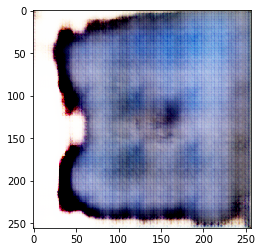

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


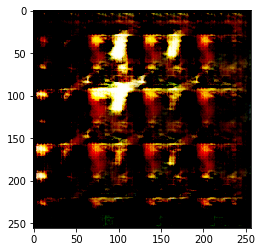

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


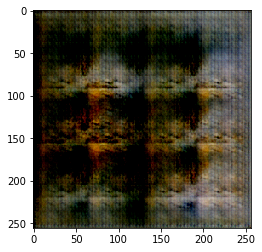

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


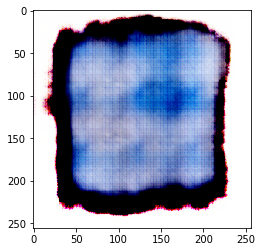

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


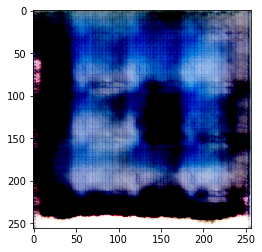

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


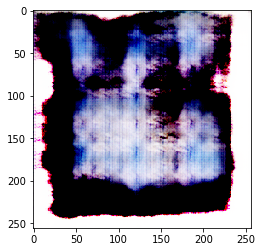

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


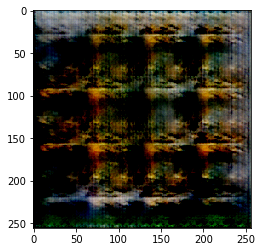

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


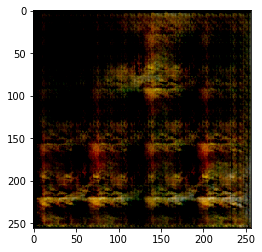

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


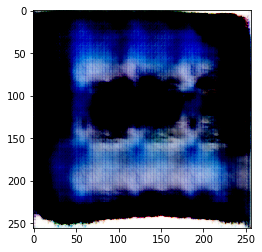

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


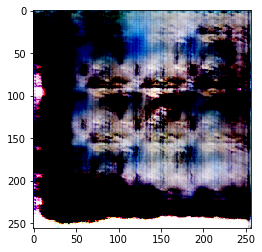

In [0]:
for i in range(10):
    z = torch.tensor(np.random.normal(0, 1, (batch_size, 200)), dtype=torch.float32).cuda()
    img = gen(z)
    img = img.cpu().detach().numpy()[0]
    img = np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.show()  